# APIs and SQL Joins Lab

The city of San Francisco wants to assess the quality of restaurants in the city. Their data is scattered across multiple sources and incomplete.

They tasked you to help them assess it.

They would like to know what the most common violations are where they happen most frequently.

## 1. Initial data inspection

To answer the question we will need to retrieve and merge data from multiple files.

Yelp provides data on food quality, that can be found at [this address](http://www.yelp.com/healthscores/feeds). We already downloaded 4 files that you can find in the [assets folder](assets/datasets/yelp/).

In the bonus part we will also use the Google Geocoding API and data on [Neighborhoods](https://www.google.com/fusiontables/DataSource?docid=1zNwsvTwj-dH0QxuuDrKFsyfNklajd7WwEyaZ2U9M#rows:id=1).

1. Open each of the files and inspect them visually (eg with Finder, open using a spreadsheet program)
- What information do they contain?
- Note the column names and datatypes

In [4]:
!dir assets\datasets\yelp

 Le volume dans le lecteur D s'appelle DATA
 Le num‚ro de s‚rie du volume est 085C-5E79

 R‚pertoire de D:\DSI_LDN_1_LESSON_NOTES\week6\day2\assets\datasets\yelp

15/11/2016  09:27    <DIR>          .
15/11/2016  09:27    <DIR>          ..
15/11/2016  09:27           316,839 businesses_utf8.csv
15/11/2016  09:27           412,612 inspections_utf8.csv
15/11/2016  09:27               106 legend_utf8.csv
15/11/2016  09:27         3,626,225 violations_utf8.csv
               4 fichier(s)        4,355,782 octets
               2 R‚p(s)  848,234,881,024 octets libres


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Local database

The first step in our analysis is to import the data into a local PostgreSQL database.

1. Connect to a local Postgres database and import the four files to four separate tables on your localhost

I'm leaving this open for you to go back and work out how to import these tables. If that's hard,
I have some code I can slack you but I'm hoping that by going through the process you can cement
it in your mind so you will be confident to do it again in future. This means also not just copy and pasting from
your neighbour, though by all means discuss. You should
be able to see the table in your postico view if you connect it to the localhost, once you have imported it.

I appreciate this can seem a little pointless, as you could just have imported the data from the csv into a pandas dataframe and explored it that way. However in general datasets may be too large to load in memory and you could use this approach to upload data to a table stored in the cloud rather than on your local computer. 

I've converted the csvs to a utf-8 format so you will not need to worry about encodings, as utf-8 is the default. In general though it's something you might encounter, as many csvs could be encoded in eg latin-1 rather than utf-8.

**Check:** What happens if you shut down your local server? Can you still see the tables in postico? What happens when you reconnect the local server?

CREATE TABLE violation 
(business_id INTEGER, date DATE, description VARCHAR);


COPY violation FROM 'D:\DSI_LDN_1_LESSON_NOTES\week6\day2\assets\datasets\yelp\violations_utf8.csv' DELIMITER ',' CSV HEADER;

CREATE TABLE legend
(minimum_score INTEGER, maximum_score INTEGER, description VARCHAR);

COPY legend FROM 'D:\DSI_LDN_1_LESSON_NOTES\week6\day2\assets\datasets\yelp\legend_utf8.csv' DELIMITER ',' CSV HEADER;

CREATE TABLE inspection
(busines_id INTEGER, score INTEGER, date DATE, type VARCHAR);

COPY inspection FROM 'D:\DSI_LDN_1_LESSON_NOTES\week6\day2\assets\datasets\yelp\inspections_utf8.csv' DELIMITER ',' CSV HEADER;

CREATE TABLE business
(business_id INTEGER, name VARCHAR, address VARCHAR, city VARCHAR, state VARCHAR, postal_code VARCHAR, latitude float, longitude float, phone_number varchar);

COPY business FROM 'D:\DSI_LDN_1_LESSON_NOTES\week6\day2\assets\datasets\yelp\businesses_utf8.csv' DELIMITER ',' CSV HEADER;


### 2.b Display the first few lines of each table (or do this in postico)

In [12]:
import pandas as pd
violation = pd.read_csv("assets/datasets/yelp/violations_utf8.csv")
business = pd.read_csv("assets/datasets/yelp/businesses_utf8.csv")
legend = pd.read_csv("assets/datasets/yelp/legend_utf8.csv")
inspection = pd.read_csv("assets/datasets/yelp/inspections_utf8.csv")

## 2.b Investigate violations

Let's focus on the violations table initially.


Answer these questions using sql:
1. How many violations are there?
- How many businesses committing violations?
- What's the average number of violations per business?

Answer these questions using python
1. Draw a plot of the violations count
- Is the average number of violations meaningful?
- Draw a plot of the normalized cumulative violation counts. Can we discard the restaurants with few violations?
- Where would you draw a threshold if you were to keep 90% of the violations?

select count(*) from violation; => 39917

select count(distinct business_id) from violation; => 5022

select count(*) *1.0 / (select count(distinct business_id) from violation) from violation; => 7.95

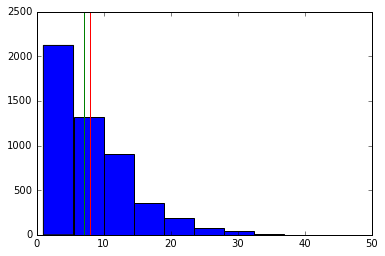

In [23]:
nb_violations = violation.groupby('business_id').apply(len)
plt.hist(nb_violations)
plt.axvline(np.mean(nb_violations),color="r")
plt.axvline(np.median(nb_violations),color="g")
plt.show()

In [31]:
nb_violations = violation.groupby('business_id').apply(len)
nb_violations = nb_violations.sort_values()
nb_violations.value_counts()

2      449
4      897
3     1339
1     1738
6     2122
5     2505
8     2851
7     3182
9     3444
10    3683
11    3887
12    4059
13    4227
15    4353
14    4473
16    4570
17    4643
18    4704
19    4757
20    4808
22    4849
21    4876
26    4895
25    4914
24    4933
27    4951
23    4969
30    4979
28    4989
29    4997
31    5004
32    5008
33    5012
36    5015
40    5016
44    5017
34    5018
38    5019
42    5020
46    5021
35    5022
dtype: int64

### 2.c Investigate Inspections

In the previous step we looked at violations count. However we also have an inspection score available in the inspections table. Let's have a look at that too.

Answer these questions using SQL:
1. What's the average score for the whole city?
1. What's the average score per business?
- Does the score correlate with the number of inspections?
- Create a dataframe from a table with the following columns:
    business_id, average_score, number_of_inspections, number_of_violations
- Use pandas to do a scatter matrix plot of average_score, number_of_inspections, number_of_violations to check for correlations

## 3 Zipcode analysis

The town administration would like to know which zip code are the ones where they should focus the inspections.

Use the information contained in the `businesses` table as well as the previous tables to answer the following questions using SQL:

1. Count the number of businesses per zipcode and sort them by descending order
- Which are the top 5 zipcodes with the worst average score?
    - restrict your analysis to the zipcodes with at least 50 businesses
    - do a simple average of the inspections scores in the postal code
- Which are the top 5 zipcodes with the highest number of violations per restaurant?
    - restrict your  analysis to the zipcodes with at least 50 businesses


## Final recommendation
Give a final recommendation on which 2 zipcodes should the administration focus and choose an appropriate plot to convince them visually.

### Bonus 1 Tableau

Connect Tableau to your localhost database. You can do this by typing `localhost` in the server, your username in the database, and tableau in the username (with no password) all within the PostgreSQL connection.

Go back through the questions from the start and redo the exploration using Tableau. For a practical understanding of where this would be used, Tableau is often used to create dashboards which others in the business (without coding skills) can use to access data. So for example, you might produce a dashboard showing inspections overlaid on a map, and this would be updated as new inspections are added to the database. Anyone would be able to log in to an online version of this dashboard (so even if they did not have the desktop version of Tableau) and view the map. 

See if you can come up with some useful dashboards for reporting.

### Bonus 2 Google Geocoding API

Instead of looking at zipcodes we may be interested in using neighbourhood names. It's beyond the scope of this lab to do a proper introduction to Geocoding and Reverse Geocoding, but we will give some pointers for further exploration.

Have a look at:
- https://developers.google.com/maps/documentation/geocoding/intro
- https://maps.googleapis.com/maps/api/geocode/json?address=
- https://maps.googleapis.com/maps/api/geocode/json?latlng=

Through this API you can retrieve an address or a neighbourhood from a lat-lon pair (reverse geocoding), or you can retrieve lat long and other information from an address (geocoding).

1. Try experimenting with and retrieving a few addresses
- Note that google imposes limits on the number of free queries
- How many missing lat-lon pairs do we have?

### Bonus 3 Pycurl
The pycurl library seems to be faster than requests in getting information from the google api.

1. See if you can extract the neighbourhood from an address using the geocode api and a bit of json parsing
- Note that you would surely hit the daily limit if you pulled each address' neighbourhood from the api

### Bonus 4 Polygons

We can find the neighbourhood using the polygons associated to each of them.
[Here](https://www.google.com/fusiontables/DataSource?docid=1zNwsvTwj-dH0QxuuDrKFsyfNklajd7WwEyaZ2U9M#rows:id=1) you can find these polygons (and we also copied them [locally](../../assets/datasets/sfneighborhoods.csv).

[This article](http://streamhacker.com/2010/03/23/python-point-in-polygon-shapely/) describes how to use the shapely package to check if a point belongs to a polygon.

- See if you can build a function that retrieves the neighbourhood for a given address using the polygon data
